In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_excel('/content/inclusive_features_usage.xlsx')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from google.colab import files

df.tail()

,user_id,feature_used,session_duration,engagement_score,accessibility_settings,age_group,gender,additional_attributes
9995,user_667,Visual Aid,110.11,1,5,Adult,Non-Binary,NaN
9996,user_3554,Visual Aid,22.44,3,2,Professional,Male,NaN
9997,user_8892,Multilingual,12.91,4,2,Senior,Non-Binary,NaN
9998,user_8014,Multilingual,19.23,3,1,Professional,NaN,LGBTQ+
9999,user_7722,Text-to-Speech,92.66,2,1,Adult,Female,NaN


In [2]:
1#Missing Values: Identify any missing values and decide how to handle them, especially in session_duration and engagement_score.
missing_values = df.isnull().sum()
print(missing_values)

user_id                      0
feature_used                 0
session_duration             0
engagement_score             0
accessibility_settings       0
age_group                    0
gender                    3997
additional_attributes     6003
dtype: int64


In [3]:
df['additional_attributes'].fillna('Unknown', inplace=True)
df['gender'].fillna('Unknown', inplace=True)
df.tail()
missing_values = df.isnull().sum()
missing_values

<ipython-input-3-32b8aac31758>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['additional_attributes'].fillna('Unknown', inplace=True)
<ipython-input-3-32b8aac31758>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

,0
user_id,0
feature_used,0
session_duration,0
engagement_score,0
accessibility_settings,0
age_group,0
gender,0
additional_attributes,0


In [4]:
2#Outliers: Detect and manage outliers in session_duration and engagement_score.
# Calculate IQR for session_duration
Q1_session = df['session_duration'].quantile(0.25)
Q3_session = df['session_duration'].quantile(0.75)
IQR_session = Q3_session - Q1_session
lower_bound_session = Q1_session - 1.5 * IQR_session
upper_bound_session = Q3_session + 1.5 * IQR_session

# Calculate IQR for engagement_score
Q1_engagement = df['engagement_score'].quantile(0.25)
Q3_engagement = df['engagement_score'].quantile(0.75)
IQR_engagement = Q3_engagement - Q1_engagement
lower_bound_engagement = Q1_engagement - 1.5 * IQR_engagement
upper_bound_engagement = Q3_engagement + 1.5 * IQR_engagement

# Cap outliers in session_duration column
df['session_duration'] = df['session_duration'].clip(lower=lower_bound_session, upper=upper_bound_session)

# Cap outliers in engagement_score column
df['engagement_score'] = df['engagement_score'].clip(lower=lower_bound_engagement, upper=upper_bound_engagement)

# Check the results (Optional)
print(df[['session_duration', 'engagement_score']].head())



   session_duration  engagement_score
0             60.77                 4
1             20.20                 5
2             93.78                 2
3             26.36                 3
4             91.67                 5


In [5]:
3#  Create a new column called high_accessibility_user, classifying users with three or more accessibility settings as a binary label (1/0 or True/False). Explain your choice and its implications for model interpretability
df.loc[df['accessibility_settings'] >= 3, 'high_accessibility_user'] = 1
df.loc[df['accessibility_settings'] < 3, 'high_accessibility_user'] = 0
df['high_accessibility_user'] = df['high_accessibility_user'].astype(int)
df.tail()
# I used 1/0 because they are preferred for machine learning models and simplify mathematical operations, ensuring consistency and efficiency.


,user_id,feature_used,session_duration,engagement_score,accessibility_settings,age_group,gender,additional_attributes,high_accessibility_user
9995,user_667,Visual Aid,110.11,1,5,Adult,Non-Binary,Unknown,1
9996,user_3554,Visual Aid,22.44,3,2,Professional,Male,Unknown,0
9997,user_8892,Multilingual,12.91,4,2,Senior,Non-Binary,Unknown,0
9998,user_8014,Multilingual,19.23,3,1,Professional,Unknown,LGBTQ+,0
9999,user_7722,Text-to-Speech,92.66,2,1,Adult,Female,Unknown,0


In [6]:
#Add a new column that combines age_group, gender, and additional_attributes to facilitate intersectional analysis. For example, label combinations as “Young Adult - Female - Person of Color.”
df['Young Adult - Female - Person of Colo'] = df['age_group'] + ' - ' + df['gender'] + ' - ' + df['additional_attributes']
df.head()

,user_id,feature_used,session_duration,engagement_score,accessibility_settings,age_group,gender,additional_attributes,high_accessibility_user,Young Adult - Female - Person of Colo
0,user_4737,Multilingual,60.77,4,4,Teenager,Unknown,LGBTQ+,1,Teenager - Unknown - LGBTQ+
1,user_1492,Text-to-Speech,20.20,5,4,Professional,Non-Binary,Unknown,1,Professional - Non-Binary - Unknown
2,user_5936,Colorblind Mode,93.78,2,2,Adult,Female,Unknown,0,Adult - Female - Unknown
3,user_5519,Colorblind Mode,26.36,3,1,Adult,Unknown,LGBTQ+,0,Adult - Unknown - LGBTQ+
4,user_1853,High Contrast Mode,91.67,5,1,Young Adult,Male,Unknown,0,Young Adult - Male - Unknown


In [8]:
#import the clean data to excell
df.to_excel('df.xlsx')
files.download('df.xlsx')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

         feature_used  engagement_score
0     Colorblind Mode          3.081068
1  High Contrast Mode          3.003488
2        Multilingual          3.021234
3      Text-to-Speech          3.045546
4          Visual Aid          3.065917


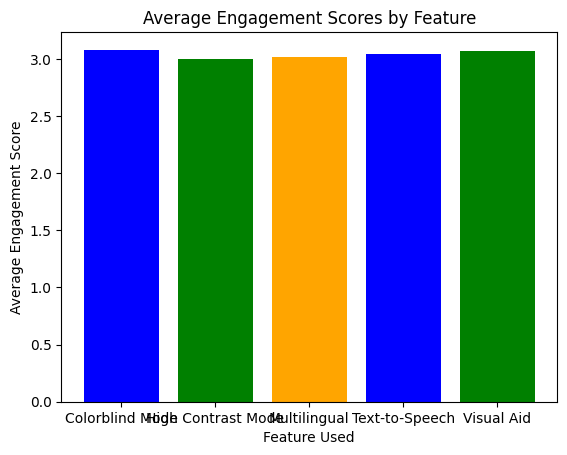

In [9]:
#Visualize engagement scores across features
avg_scores = df.groupby("feature_used")["engagement_score"].mean().reset_index()

# Step 3: Print the results to understand
print(avg_scores)

# Step 4: Visualize the average scores
plt.bar(avg_scores["feature_used"], avg_scores["engagement_score"], color=['blue', 'green', 'orange'])
plt.title("Average Engagement Scores by Feature")
plt.xlabel("Feature Used")
plt.ylabel("Average Engagement Score")
plt.show()
unique_features = df["feature_used"].unique()




      age_group  engagement_score
0         Adult          2.946929
1  Professional          3.103015
2        Senior          3.031589
3      Teenager          3.096115
4   Young Adult          3.043653


Text(0, 0.5, 'Average Engagement Score')

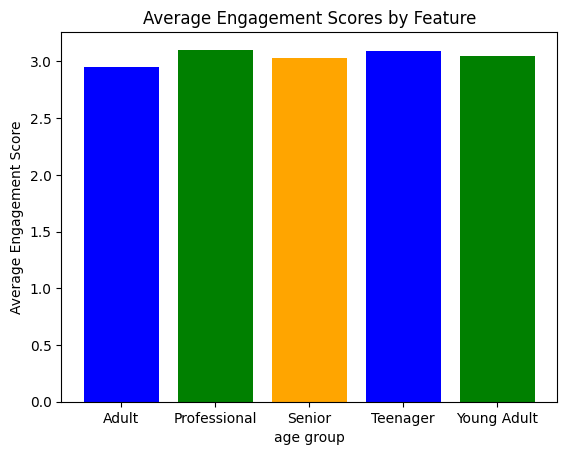

In [10]:
#Visualize engagement scores across age group
avg_scores2 = df.groupby("age_group")["engagement_score"].mean().reset_index()

# Step 3: Print the results to understand
print(avg_scores2)

# Step 4: Visualize the average scores
plt.bar(avg_scores2["age_group"], avg_scores2["engagement_score"], color=['blue', 'green', 'orange'])
plt.title("Average Engagement Scores by Feature")
plt.xlabel("age group")
plt.ylabel("Average Engagement Score")

       gender  engagement_score
0      Female          3.046231
1        Male          3.000986
2  Non-Binary          3.067036
3     Unknown          3.052289


Text(0, 0.5, 'Average Engagement Score')

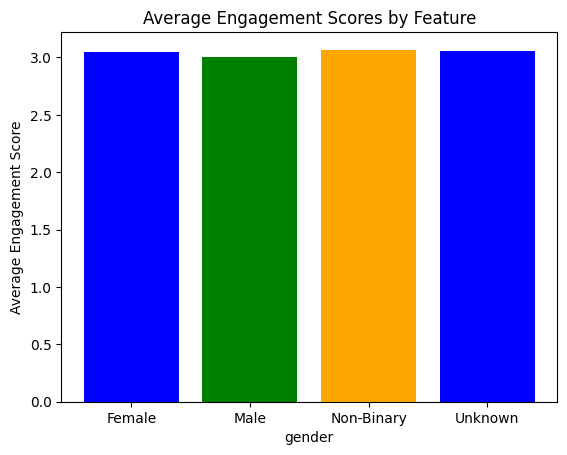

In [11]:
#Visualize engagement scores across gender
avg_scores3 = df.groupby("gender")["engagement_score"].mean().reset_index()

# Step 3: Print the results to understand
print(avg_scores3)

# Step 4: Visualize the average
plt.bar(avg_scores3["gender"], avg_scores3["engagement_score"], color=['blue', 'green', 'orange'])
plt.title("Average Engagement Scores by Feature")
plt.xlabel("gender")
plt.ylabel("Average Engagement Score")

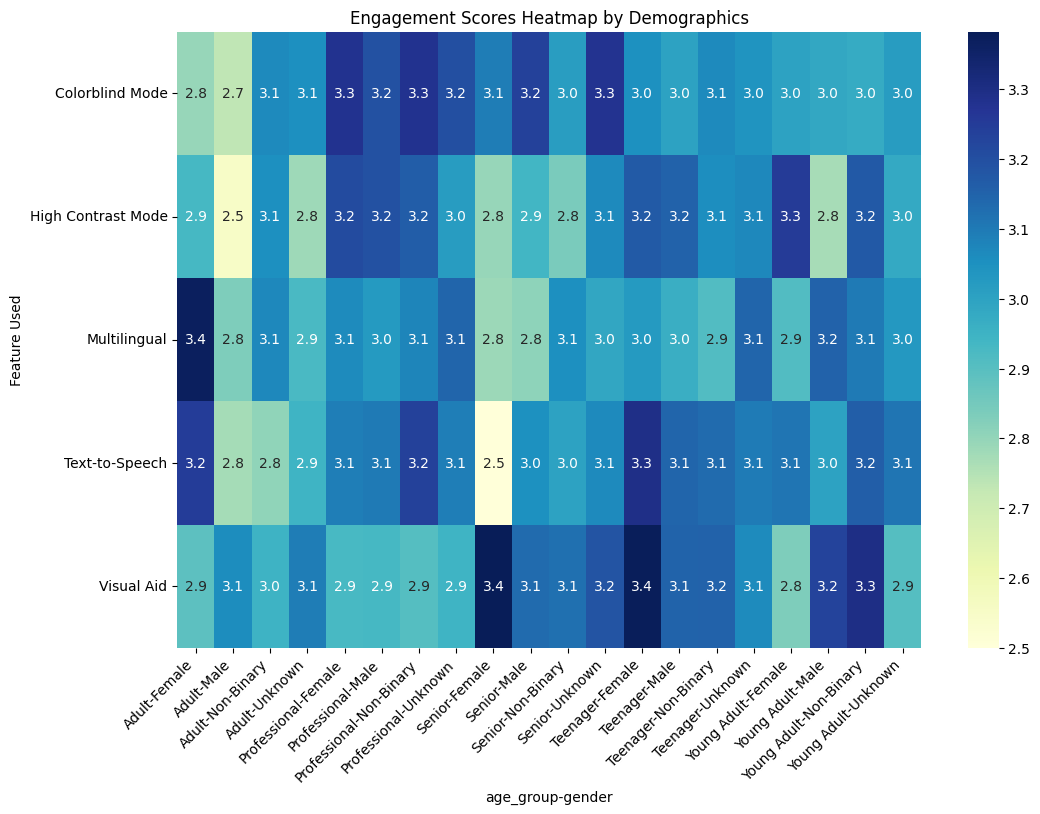

In [12]:
grouped = df.groupby(["feature_used", "age_group", "gender"])["engagement_score"].mean().reset_index()
highest_engagement = grouped.loc[grouped.groupby("feature_used")["engagement_score"].idxmax()]
heatmap_data = grouped.pivot_table(index="feature_used", columns=["age_group", "gender"], values="engagement_score")

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Engagement Scores Heatmap by Demographics")
plt.ylabel("Feature Used")
plt.xticks(rotation=45, ha='right')
plt.show()

In [13]:
# Step 1: Feature Engineering
# (a) Average session duration per feature used
avg_session_duration = df.groupby('feature_used')['session_duration'].mean().reset_index()
avg_session_duration.rename(columns={'session_duration': 'avg_session_duration'}, inplace=True)

# Merge with original data
df = df.merge(avg_session_duration, on='feature_used')

# (b) Average engagement score by accessibility settings
avg_engagement_score = df.groupby('accessibility_settings')['engagement_score'].mean().reset_index()
avg_engagement_score.rename(columns={'engagement_score': 'avg_engagement_score'}, inplace=True)

# Merge with original data
df = df.merge(avg_engagement_score, on='accessibility_settings')

# Step 2: Prepare Features and Target for Modeling
X = df[['session_duration', 'engagement_score', 'accessibility_settings', 'avg_session_duration', 'avg_engagement_score']]
y = df['high_accessibility_user']

# Step 3: Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Train the Predictive Model i understand teh modellll
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Step 5: Make Predictions
y_pred = model.predict(X_test)

# Step 6: Evaluate the Model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1542
           1       1.00      1.00      1.00      1458

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000

